In [1]:
import gym
import numpy as np
import torch
import wandb

import argparse
import pickle
import random
import sys

sys.path.append('/Users/shiro/research/projects/rl-nlp/can-wikipedia-help-offline-rl/code')

from decision_transformer.evaluation.evaluate_episodes import (
    evaluate_episode,
    evaluate_episode_rtg,
)
from decision_transformer.models.decision_transformer import DecisionTransformer
from decision_transformer.models.mlp_bc import MLPBCModel
from decision_transformer.training.act_trainer import ActTrainer
from decision_transformer.training.seq_trainer import SequenceTrainer

from utils import get_optimizer
import os

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
DecisionTransformer(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=Tr

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


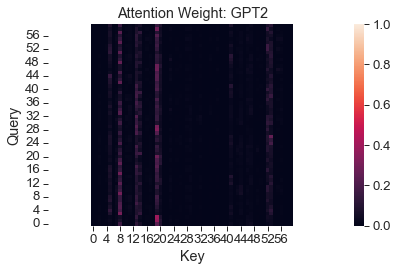

Starting new experiment: halfcheetah medium
1000 trajectories, 1000000 timesteps found
Average return: 4770.33, std: 355.75
Max return: 5309.38, min: -310.23
Loading from pretrained
DecisionTransformer(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_af

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


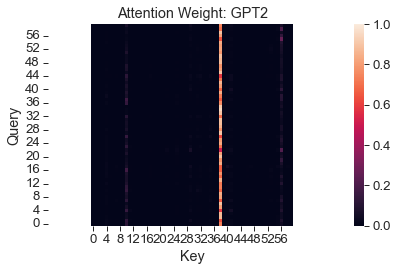

Starting new experiment: walker2d medium
1190 trajectories, 999995 timesteps found
Average return: 2852.09, std: 1095.44
Max return: 4226.94, min: -6.61
Loading from pretrained
DecisionTransformer(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


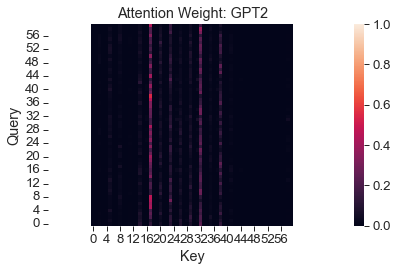

In [3]:
seed = 666

model_name = 'gpt2'

env_name_list = ['hopper', 'halfcheetah', 'walker2d']

layer = 1
batchid = 0

for env_name in env_name_list:
# env_name = 'walker2d'
    dataset_name = 'medium'

    if model_name == 'gpt2':
        pretrained_lm = 'gpt2'
    elif model_name == 'clip':
        pretrained_lm = 'openai/clip-vit-base-patch32'
    elif model_name == 'igpt':
        pretrained_lm = 'openai/imagegpt-small'

    variant = {
        'embed_dim': 128,
        'n_layer': 3,
        'n_head': 1,
        'activation_function': 'relu',
        'dropout': 0.2, # 0.1
        'load_checkpoint': False,
        'seed': seed,
        'outdir': f"checkpoints/{model_name}_{dataset_name}_{env_name}_{seed}",
        'env': env_name,
        'dataset': dataset_name,
        'model_type': 'dt',
        'K': 20, # 2
        'pct_traj': 1.0,
        'batch_size': 100,  # 64
        'num_eval_episodes': 100,
        'max_iters': 40,
        'num_steps_per_iter': 2500,
        'pretrained_lm': pretrained_lm,
        'gpt_kmeans': None,  # 1000 <-- メモリに乗らない
        'kmeans_cache': None,  # 'kmeans_cache/gpt2_lm_1000.pt'
        'frozen': False,
        'extend_positions': False,
        'share_input_output_proj': True
    }

    torch.manual_seed(variant["seed"])
    os.makedirs(variant["outdir"], exist_ok=True)
    # device = variant.get("device", "cuda")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    log_to_wandb = variant.get("log_to_wandb", False)

    env_name, dataset = variant["env"], variant["dataset"]
    model_type = variant["model_type"]
    exp_prefix = 'gym-experiment'
    group_name = f"{exp_prefix}-{env_name}-{dataset}"
    exp_prefix = f"{group_name}-{random.randint(int(1e5), int(1e6) - 1)}"

    if env_name == "hopper":
        env = gym.make("Hopper-v3")
        max_ep_len = 1000
        env_targets = [3600, 1800]  # evaluation conditioning targets
        scale = 1000.0  # normalization for rewards/returns
    elif env_name == "halfcheetah":
        env = gym.make("HalfCheetah-v3")
        max_ep_len = 1000
        env_targets = [12000, 6000]
        scale = 1000.0
    elif env_name == "walker2d":
        env = gym.make("Walker2d-v3")
        max_ep_len = 1000
        env_targets = [5000, 2500]
        scale = 1000.0
    elif env_name == "reacher2d":
        from decision_transformer.envs.reacher_2d import Reacher2dEnv

        env = Reacher2dEnv()
        max_ep_len = 100
        env_targets = [76, 40]
        scale = 10.0
    else:
        raise NotImplementedError

    if model_type == "bc":
        env_targets = env_targets[
            :1
        ]  # since BC ignores target, no need for different evaluations

    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    # load dataset
    dataset_path = f"../data/{env_name}-{dataset}-v2.pkl"
    with open(dataset_path, "rb") as f:
        trajectories = pickle.load(f)

    # save all path information into separate lists
    mode = variant.get("mode", "normal")
    states, traj_lens, returns = [], [], []
    for path in trajectories:
        if mode == "delayed":  # delayed: all rewards moved to end of trajectory
            path["rewards"][-1] = path["rewards"].sum()
            path["rewards"][:-1] = 0.0
        states.append(path["observations"])
        traj_lens.append(len(path["observations"]))
        returns.append(path["rewards"].sum())
    traj_lens, returns = np.array(traj_lens), np.array(returns)

    # used for input normalization
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

    num_timesteps = sum(traj_lens)

    print("=" * 50)
    print(f"Starting new experiment: {env_name} {dataset}")
    print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
    print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
    print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
    print("=" * 50)

    K = variant["K"]
    batch_size = variant["batch_size"]
    num_eval_episodes = variant["num_eval_episodes"]
    pct_traj = variant.get("pct_traj", 1.0)

    # only train on top pct_traj trajectories (for %BC experiment)
    num_timesteps = max(int(pct_traj * num_timesteps), 1)
    sorted_inds = np.argsort(returns)  # lowest to highest
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:]

    # used to reweight sampling so we sample according to timesteps instead of trajectories
    p_sample = traj_lens[sorted_inds] / sum(traj_lens[sorted_inds])

    def discount_cumsum(x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def get_batch(batch_size=256, max_len=K):
        batch_inds = np.random.choice(
            np.arange(num_trajectories),
            size=batch_size,
            replace=True,
            p=p_sample,  # reweights so we sample according to timesteps
        )

        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        for i in range(batch_size):
            traj = trajectories[int(sorted_inds[batch_inds[i]])]
            si = random.randint(0, traj["rewards"].shape[0] - 1)

            # get sequences from dataset
            s.append(traj["observations"][si : si + max_len].reshape(1, -1, state_dim))
            a.append(traj["actions"][si : si + max_len].reshape(1, -1, act_dim))
            r.append(traj["rewards"][si : si + max_len].reshape(1, -1, 1))
            if "terminals" in traj:
                d.append(traj["terminals"][si : si + max_len].reshape(1, -1))
            else:
                d.append(traj["dones"][si : si + max_len].reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= max_ep_len] = (
                max_ep_len - 1
            )  # padding cutoff
            rtg.append(
                discount_cumsum(traj["rewards"][si:], gamma=1.0)[
                    : s[-1].shape[1] + 1
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] <= s[-1].shape[1]:
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate(
                [np.zeros((1, max_len - tlen, state_dim)), s[-1]], axis=1
            )
            s[-1] = (s[-1] - state_mean) / state_std
            a[-1] = np.concatenate(
                [np.ones((1, max_len - tlen, act_dim)) * -10.0, a[-1]], axis=1
            )
            r[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = (
                np.concatenate([np.zeros((1, max_len - tlen, 1)), rtg[-1]], axis=1)
                / scale
            )
            timesteps[-1] = np.concatenate(
                [np.zeros((1, max_len - tlen)), timesteps[-1]], axis=1
            )
            mask.append(
                np.concatenate(
                    [np.zeros((1, max_len - tlen)), np.ones((1, tlen))], axis=1
                )
            )

        s = torch.from_numpy(np.concatenate(s, axis=0)).to(
            dtype=torch.float32, device=device
        )
        a = torch.from_numpy(np.concatenate(a, axis=0)).to(
            dtype=torch.float32, device=device
        )
        r = torch.from_numpy(np.concatenate(r, axis=0)).to(
            dtype=torch.float32, device=device
        )
        d = torch.from_numpy(np.concatenate(d, axis=0)).to(
            dtype=torch.long, device=device
        )
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).to(
            dtype=torch.float32, device=device
        )
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).to(
            dtype=torch.long, device=device
        )
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).to(device=device)

        return s, a, r, d, rtg, timesteps, mask

    (
        states,
        actions,
        rewards,
        dones,
        rtg,
        timesteps,
        attention_mask,
    ) = get_batch(batch_size)
    action_target = torch.clone(actions)
    
    model = DecisionTransformer(
        args=variant,
        state_dim=state_dim,
        act_dim=act_dim,
        max_length=K,
        max_ep_len=max_ep_len,
        hidden_size=variant["embed_dim"],
        n_layer=variant["n_layer"],
        n_head=variant["n_head"],
        n_inner=4 * variant["embed_dim"],
        activation_function=variant["activation_function"],
        n_positions=1024,
        resid_pdrop=variant["dropout"],
        attn_pdrop=0.1,
    )
    if variant["load_checkpoint"]:
        state_dict = torch.load(variant["load_checkpoint"])
        model.load_state_dict(state_dict)
        print(f"Loaded from {variant['load_checkpoint']}")

    model.eval()

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    for block_id in range(len(model.transformer.h)):
        model.transformer.h[block_id].ln_1.register_forward_hook(get_activation(f'{block_id}.ln_1'))
        model.transformer.h[block_id].attn.c_attn.register_forward_hook(get_activation(f'{block_id}.attn.c_attn'))
        model.transformer.h[block_id].attn.c_proj.register_forward_hook(get_activation(f'{block_id}.attn.c_proj'))
        model.transformer.h[block_id].attn.attn_dropout.register_forward_hook(get_activation(f'{block_id}.attn.attn_dropout'))
        model.transformer.h[block_id].attn.resid_dropout.register_forward_hook(get_activation(f'{block_id}.attn.resid_dropout'))
        model.transformer.h[block_id].ln_2.register_forward_hook(get_activation(f'{block_id}.ln_2'))
        model.transformer.h[block_id].mlp.c_fc.register_forward_hook(get_activation(f'{block_id}.mlp.c_fc'))
        model.transformer.h[block_id].mlp.c_proj.register_forward_hook(get_activation(f'{block_id}.mlp.c_proj'))
        model.transformer.h[block_id].mlp.act.register_forward_hook(get_activation(f'{block_id}.mlp.act'))
        model.transformer.h[block_id].mlp.dropout.register_forward_hook(get_activation(f'{block_id}.mlp.dropout'))

    state_preds, action_preds, reward_preds, all_embs = model.forward(
        states,
        actions,
        rewards,
        rtg[:, :-1],
        timesteps,
        attention_mask=attention_mask,
    )

    sns.set_style("ticks")
    sns.set_context("paper", 1.5, {"lines.linewidth": 2})

    query = activation[f'{layer}.attn.c_attn'][batchid, :, :768]  # 0, 5, 11
    key = activation[f'{layer}.attn.c_attn'][batchid, :, 768: 1536]  # 0, 5, 11

    att_weight_mat = torch.softmax(torch.matmul(query, key.t()) / np.sqrt(768), dim=1)

    # ax = sns.heatmap(att_weight_mat, vmin=0, vmax=0.03)
    ax = sns.heatmap(att_weight_mat, vmin=0, vmax=1)
    ax.axis('equal')
    plt.ylim(0, K * 3)
    plt.xlim(0, K * 3)
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.title(f'Attention Weight: {model_name.upper()}')
    plt.tight_layout()
    plt.savefig(f'figs/attention_{model_name}_{env_name}_{dataset_name}_{seed}_layer{layer}_batchid{batchid}.pdf')
    plt.show()